In [33]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix, plot_precision_recall_curve

# instead want to try plot_precision_recall_curve

In [18]:
df = pd.read_csv('../data/loan_data.csv')

In [19]:
df.columns = [x.replace('.','_') for x in df.columns]
df.columns

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'not_fully_paid'],
      dtype='object')

In [20]:
df['fully_paid'] = 1 - df.not_fully_paid
df.drop('not_fully_paid', axis=1, inplace=True)

In [21]:
df.fully_paid.value_counts()

1    8045
0    1533
Name: fully_paid, dtype: int64

# Splitting the data

In [22]:
X = df.drop('fully_paid', axis = 1)
y = df.fully_paid
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=675, test_size=0.2)

# Base Model

In [29]:
numeric_features = X.select_dtypes(exclude='object').columns
cat_features = df.select_dtypes('object').columns

numeric_transformer = Pipeline(steps=[('scalar',StandardScaler())])
cat_transformer = Pipeline(steps=[('one_hot',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numeric_features),
    ('cat',cat_transformer,cat_features)])

knn = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('knn_classifier', KNeighborsClassifier())])

In [30]:
knn.fit(X_train,y_train)
y_preds = knn.predict(X_test)
f1_score(y_test, y_preds)

0.9019721577726217

In [32]:
confusion_matrix(y_test, y_preds)

array([[  23,  276],
       [  62, 1555]], dtype=int64)

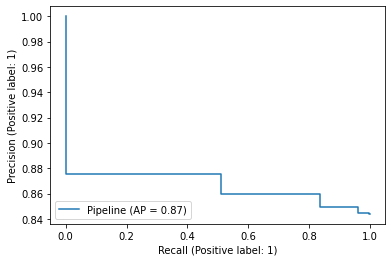

In [34]:
plot_precision_recall_curve(knn ,X_test, y_test)

# Unbalanced Model With Hyperparameter Tuning

*for knn do i need hyperparameter tuning? Should use grid search for number of neighbors*

# Model with undersampling and hyperparameter tuning

# Model with oversampling and hyperparameter tuning

# Training of final model